# Model Comparison Jonas vs. CI_B

- Goal is to compare the test-set performance of both models on andrea_split = 6
- compare the ensembles

In [27]:
import os
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'

/tf/notebooks/schnemau/xAI_stroke_3d


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

from sklearn import metrics
import Utils_maurice as utils
from functions.augmentation3d import zoom, rotate, flip, shift

In [29]:
which_split = 6
(X_train, X_valid, X_test, X_tab_train, X_tab_valid, X_tab_test), (Y_train, Y_valid, Y_test), results = utils.read_and_split_img_data_andrea_maurice(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split)

Y_train_MRS = to_categorical(Y_train)
Y_valid_MRS = to_categorical(Y_valid)
Y_test_MRS = to_categorical(Y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], X_valid.shape[3], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1))

In [30]:
C = Y_train_MRS.shape[1]
batch_size = 5
epochs = 250
ntrain = 325
nvalid = 40
ntest = 40

# Ontram CIB

In [31]:
ontram_1 = ontram(utils.img_model_linear(X_train.shape[1:], 1))
ontram_1.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])
ontram_1.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_1_ontram_CIB_fini.h5')

In [32]:
predic = predict_ontram(ontram_1, data = (X_test, Y_test_MRS))

In [33]:
predic

{'cdf': array([[0.        , 0.9572038 , 1.        ],
        [0.        , 0.89199215, 1.        ],
        [0.        , 0.9229489 , 1.        ],
        [0.        , 0.7343256 , 1.        ],
        [0.        , 0.9796539 , 1.        ],
        [0.        , 0.7429625 , 1.        ],
        [0.        , 0.870585  , 1.        ],
        [0.        , 0.88178533, 1.        ],
        [0.        , 0.85786414, 1.        ],
        [0.        , 0.859974  , 1.        ],
        [0.        , 0.95826864, 1.        ],
        [0.        , 0.74368435, 1.        ],
        [0.        , 0.764462  , 1.        ],
        [0.        , 0.8921922 , 1.        ],
        [0.        , 0.7491608 , 1.        ],
        [0.        , 0.71885866, 1.        ],
        [0.        , 0.9756644 , 1.        ],
        [0.        , 0.6721735 , 1.        ],
        [0.        , 0.90012145, 1.        ],
        [0.        , 0.9863197 , 1.        ],
        [0.        , 0.69432074, 1.        ],
        [0.        , 0.8919

In [34]:
pred0 = utils.sigmoid(ontram_1.predict(X_test))
pred1 = 1-pred0

In [52]:
y_pred_ontram = predict_ontram(ontram_1, data = (X_test, Y_test_MRS))['pdf']

In [53]:
y_pred_ontram_class = predict_ontram(ontram_1, data = (X_test, Y_test_MRS))['pred_class']

In [54]:
y_pred_ontram_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
1-np.mean(pred0)

NameError: name 'pred0' is not defined

In [37]:
np.mean(y_pred_ontram[:,1])

0.14761

In [72]:
auc = roc_auc_score(Y_test, y_pred_ontram_class)

# Print the AUC score
print("AUC Score:", auc)

AUC Score: 0.5


No handles with labels found to put in legend.


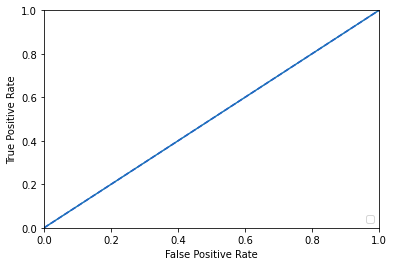

In [71]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, (y_pred_ontram_class))
roc_auc = metrics.auc(fpr, tpr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

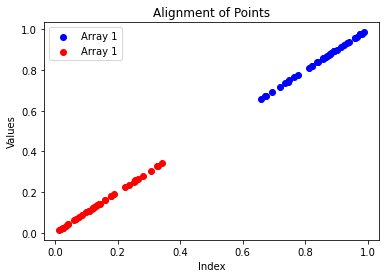

In [41]:
plt.scatter(pred0, y_pred_ontram[:,0], color='blue', label='Array 1')
plt.scatter(pred1, y_pred_ontram[:,1], color='red', label='Array 1')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Alignment of Points')
plt.legend()

# Ontram CIB_LSX

In [38]:
# function for preprocessing
def train_preprocessing2(data, label):
    """Process training data."""
    volume = data[0] # intercept: image
    tabular = data[1] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (volume, tabular), label

# Define data sets
train_data_2 = tf.data.Dataset.from_tensor_slices((X_train[:ntrain], X_tab_train[:ntrain]))
train_labels_2 = tf.data.Dataset.from_tensor_slices((Y_train_MRS[:ntrain]))

valid_data_2 = tf.data.Dataset.from_tensor_slices((X_valid[:ntrain], X_tab_valid[:ntrain]))
valid_labels_2 = tf.data.Dataset.from_tensor_slices((Y_valid_MRS[:nvalid]))

test_data_2 = tf.data.Dataset.from_tensor_slices((X_test[:ntest], X_tab_test[:ntest]))
test_labels_2 = tf.data.Dataset.from_tensor_slices((Y_test_MRS[:ntest]))

train_loader_2 = tf.data.Dataset.zip((train_data_2, train_labels_2))
validation_loader_2 = tf.data.Dataset.zip((valid_data_2, valid_labels_2))
test_loader_2 = tf.data.Dataset.zip((test_data_2, test_labels_2))

train_dataset_MRS_2 = (train_loader_2.shuffle(ntrain)
                 .map(train_preprocessing2)
                 .batch(batch_size))

validation_dataset_MRS_2 = (validation_loader_2.batch(batch_size))

test_dataset_MRS_2 = (test_loader_2.batch(len(X_test[:ntest])))

In [39]:
CI_B = utils.img_model_linear(X_train.shape[1:], 1)
LS_X = utils.mod_linear_shift(X_tab_train.shape[1])
mod_ontram_CIBLSX = ontram(CI_B, LS_X)
mod_ontram_CIBLSX.compile(optimizer = keras.optimizers.Adam(),
            loss = ontram_loss(C, batch_size),
            metrics = [ontram_acc(C, batch_size)])    
mod_ontram_CIBLSX.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_1_1_ontram_CIBLSX_.h5')

In [42]:
y_pred_ontram = predict_ontram(mod_ontram_CIBLSX, data = test_dataset_MRS_2)['pdf']

In [44]:
np.mean(y_pred_ontram[:,0])

0.79801303

In [24]:
predict_ontram(mod_ontram_CIBLSX, data = test_dataset_MRS_2)['nll']

0.32054135

In [75]:
predict_ontram(mod_ontram_CIBLSX, data = test_dataset_MRS_2)['nll']

0.32054135

In [25]:
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [58]:
y_pred_ontramlsx = predict_ontram(mod_ontram_CIBLSX, data = test_dataset_MRS_2)['pdf']

In [59]:
np.mean(y_pred_ontramlsx[:,0])

0.79801303

In [60]:
np.mean(y_pred_ontramlsx[:,1])

0.20198695

In [50]:
y_pred_ontramlsx = predict_ontram(mod_ontram_CIBLSX, data = test_dataset_MRS_2)['pred_class']

In [51]:
y_pred_ontramlsx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

No handles with labels found to put in legend.


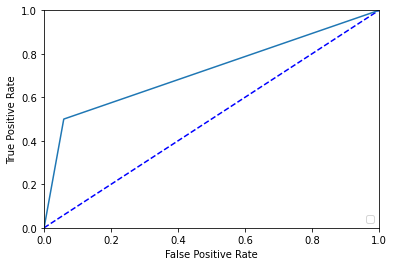

In [68]:
fpr, tpr, threshold = metrics.roc_curve(Y_test[:ntest], (y_pred_ontramlsx))
roc_auc = metrics.auc(fpr, tpr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

# Jonas

In [45]:
import functions_model_definition as md

In [46]:
path = '/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5'

input_dim = X_train.shape[1:]
output_dim = 1

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

# call model
model_3d2 = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d2.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

model_3d2.load_weights(path)

In [47]:
out = model_3d2.predict(X_test) 

In [48]:
pred_jonas_1 = out
pred_jonas_0 = 1-pred_jonas_1

In [49]:
np.mean(pred_jonas_1)

0.15204932

In [50]:
np.mean(pred_jonas_0)

0.8479507

# Try 